### Naive Experiment part 3 (Wasserstein GAN)

In [2]:
import torch
import torchvision

from collections import OrderedDict
from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.cuda.is_available()

True

### Convolutional neural network

Let me define the following neural network that has to predict labels of images from CIFAR100

In [4]:
class SimpleConvNet(torch.nn.Module):
    def __new__(cls, n_classes=100):
        return torch.nn.Sequential(OrderedDict([
            ('layer_1', torch.nn.Conv2d(3, 128, 7, bias=False)),
            ('layer_1_bn', torch.nn.BatchNorm2d(128)),
            ('layer_1_relu', torch.nn.LeakyReLU()),
            ('layer_1_mp', torch.nn.MaxPool2d(2)),
            # ('layer_1_drop', torch.nn.Dropout(0.3)),

            ('layer_2', torch.nn.Conv2d(128, 256, 5, bias=False)),
            ('layer_2_bn', torch.nn.BatchNorm2d(256)),
            # ('layer_2_drop', torch.nn.Dropout(0.3)),
            ('layer_2_relu', torch.nn.LeakyReLU()),

            ('layer_3', torch.nn.Conv2d(256, 256, 5, bias=False)),
            ('layer_3_bn', torch.nn.BatchNorm2d(256)),
            # ('layer_3_drop', torch.nn.Dropout(0.3)),
            ('layer_3_relu', torch.nn.LeakyReLU()),

            ('flatten', torch.nn.Flatten()),

            ('layer_4', torch.nn.Linear(256 * 5 * 5, 512)),
            # ('layer_4_drop', torch.nn.Dropout(0.3)),
            ('layer_4_relu', torch.nn.ReLU()),

            ('layer_5', torch.nn.Linear(512, n_classes)),
        ]))

### SKD

Upload SKD filters



In [13]:
import os
import pickle

path = os.path.join('drive', 'My Drive','filters', 'Filters_1_layer_3.pkl')
with open(path, 'rb') as handle:
    tensor = pickle.load(handle)

In [14]:
#conv1_tensor_ = torch.cat([tensor_,tensor])
#conv2_tensor_ = torch.cat([tensor_,tensor])
conv3_tensor_= torch.cat([tensor_,tensor])

In [15]:
filters_1 = conv1_tensor_.reshape(8*128*3,7,7)
filters_2 = conv2_tensor_.reshape(8*256*128,5,5)
filters_3 = conv3_tensor_.reshape(8*256*256,5,5)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

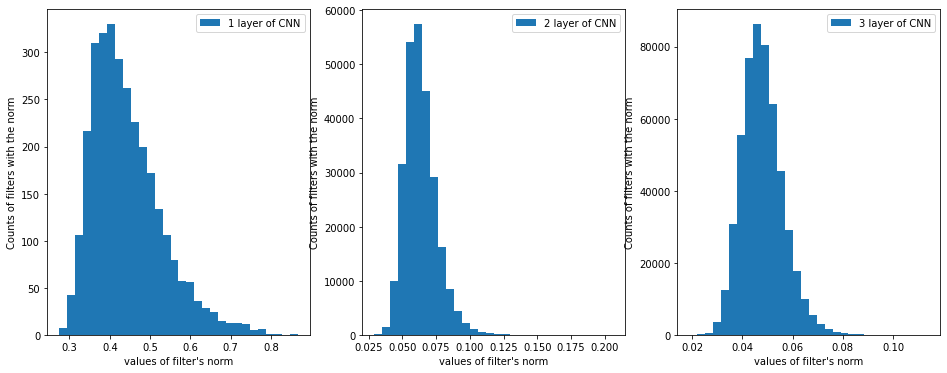

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax = ax.flatten()
for idx in range(3):
  ax[idx].hist(norms[idx], density=False, bins=30,label= str(idx + 1) + " layer of CNN") 
  ax[idx].set_ylabel('Counts of filters with the norm')
  ax[idx].set_xlabel("values of filter's norm")
  ax[idx].legend()
plt.show();

It is worth noticing, that these filters was obtaine without weight_decay and annealing learning rate

Also, one can wrap SKD filters of each layer to train loaders as follow

In [17]:
SKD_convolutional_weights = {n: filters for n,filters in zip( ['layer_1','layer_2','layer_3'],\
                                                             [filters_1,filters_2,filters_3])}

In [18]:
BATCH_1 = 20
BATCH_2 = 300
BATCH_3 = 300
train_loader_1 = torch.utils.data.DataLoader(dataset=SKD_convolutional_weights['layer_1'],batch_size=BATCH_1,shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(dataset=SKD_convolutional_weights['layer_2'],batch_size=BATCH_2,shuffle=True)
train_loader_3 = torch.utils.data.DataLoader(dataset=SKD_convolutional_weights['layer_3'],batch_size = BATCH_3, shuffle=True )

### Fake sampler:
Define sampler from distribution of current fitness filters of the Convolutional Neural network.

In [19]:
model = SimpleConvNet(n_classes =10).cuda()
convolutional_weights_CNN = {name: structure.weight  for name,structure in model.named_modules() if isinstance(structure,torch.nn.Conv2d) }
#convolutional_weights_CNN['layer_1'].shape = torch.Size([128,3,7,7])
#convolutional_weights_CNN['layer_2'].shape = torch.Size([256,128,5,5])
# convolutional_weights_CNN['layer_3'].shape = torch.Size([256,256,5,5])

In [20]:
convolutional_weights_CNN = {  key: convolutional_weights_CNN[key].reshape(-1,convolutional_weights_CNN[key].shape[-2],\
                                                                           convolutional_weights_CNN[key].shape[-1])         \
                             for key in convolutional_weights_CNN.keys()}

#convolutional_weights_CNN['layer_1'].shape = torch.Size([128*3,7,7])
#convolutional_weights_CNN['layer_2'].shape = torch.Size([256*128,5,5])
# convolutional_weights_CNN['layer_3'].shape = torch.Size([256*256,5,5])

Dictionary of convolutional neural network:



1.   first layer:  128*3,    7x7
2.   second_layer: 256*128,  5x5
3.   third_layer:  256*256,  5x5



The previous version was as follow :

In [21]:
class fake_data_sampler:

  def __init__(self, batch_size):
    super().__init__()

    
    self.batch_size = batch_size

  def __iter__(self):
    return self

  def __next__(self, tensor,low, high):
    return tensor[low : high]

  def sample(self,tensor):
    assert self.batch_size <= tensor.shape[0]
    low = np.random.randint(tensor.shape[0] - self.batch_size)
    high = low + self.batch_size
    return self.__next__(tensor,low,high) 

In [22]:
fake_sampler = fake_data_sampler(batch_size = 18)
fake_sampler.sample(convolutional_weights_CNN['layer_1']).shape

torch.Size([18, 7, 7])

New version of fake_data_sampler

### Wasserstein GAN : Critic

In [23]:
class Critic(torch.nn.Module):    
    
    def __init__(self, dim, size_title , kernels_5x5 = None, kernels_7x7 = None):
        super().__init__()
        #### parameters ####
        # dim: out_channels for filters (dim, 2*dim, 4*dim)
        # size_title : title for size of filters ["5x5","7x7"]

        assert  size_title in ["5x5","7x7"]
        
        self.dim = dim
        self.kernels_5x5 = kernels_5x5
        self.kernels_7x7 = kernels_7x7
        self.size_title = size_title


    
        if self.kernels_5x5 is None:
            self.kernels_5x5 = [3,2,2]
        else:
            assert isinstance(self.kernels_5x5,list)

            
        if self.kernels_7x7 is None:
            self.kernels_7x7 = [3,3,3]
        else:
            assert isinstance(self.kernels_7x7,list)
            
    
        dictionary_of_kernels = {"5x5":self.kernels_5x5,\
                             "7x7":self.kernels_7x7}

        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1   ,out_channels = dim ,     kernel_size = dictionary_of_kernels[self.size_title][0] ,  stride = 1 ,     padding = 0  ,    bias = False  ),
            torch.nn.BatchNorm2d(dim),
            torch.nn.LeakyReLU(),

            torch.nn.Conv2d(in_channels = dim ,out_channels = 2*dim,    kernel_size = dictionary_of_kernels[self.size_title][1] ,  stride = 1 ,     padding = 0 ,     bias= False),
            torch.nn.BatchNorm2d(2*dim),
            torch.nn.LeakyReLU(),

            torch.nn.Conv2d(in_channels = 2*dim ,out_channels = 4*dim,    kernel_size = dictionary_of_kernels[self.size_title][2],  stride = 1 ,     padding = 0 ,     bias= False),
            torch.nn.BatchNorm2d(4*dim),
            torch.nn.LeakyReLU()
        )
        # [batch, 4*dim,1,1]
        self.fc = torch.nn.Linear(in_features= 4*dim, out_features = 1)

    def forward(self,x):
        x = self.net(x)
        x = x.view(x.shape[0], 4*self.dim)
        return self.fc(x) 
        # torch.Size([batch_size, 1])


In [24]:
def gradient_penalty(critic, real_data, fake_data):
    

    ## Notion: before this function real and fake_data one has to be as follow
    # real_data : torch.Size([batch_size,1,size,size])
    # fake_data : torch.Size([batch_size,1,size,size])
    
    batch_size = real_data.shape[0]
    assert batch_size == fake_data.shape[0]

    
    # sample epsilon = t
    t = torch.rand(batch_size,1,1,1).cuda()

    # create x_t
    interpolated =  t*real_data.data + (1-t)*fake_data.data
    interpolated.requires_grad = True

    #apply critic to x_t
    discrim_output = critic(interpolated)

    # Computes and returns the sum of gradients of outputs w.r.t. the inputs.
    gradients = torch.autograd.grad(outputs = discrim_output, inputs = interpolated,
                                  grad_outputs = torch.ones(discrim_output.size()).cuda() ,
                                  create_graph=True, retain_graph=True)[0]

    gradients = gradients.reshape(batch_size,-1)


    #compute gradient norm
    #gradient_norm = torch.norm(gradients)
    gradient_norm = torch.linalg.norm(gradients,dim=1)
 

    return ((gradient_norm - 1)**2).mean(),  gradient_norm.mean()

   ### gradients is torch.Size([batch_size])

### WGAN Gradient penalty vs WGAN Lipshitz Penalty
Let me try to use tow different approaches for training of critic. The first approach is standard WGAN Penalty gradient , where as the second way is based on penalizing the violation of Lipshitz constant , that was published at first here (see p.6) https://openreview.net/pdf?id=B1hYRMbCW

In accordance with the article:
$$ Loss = \mathcal{D}(x_{fake}) - \mathcal{D}(x_{true}) + \lambda \max \{ 0,(|| \nabla \mathcal{D(\hat{x})} || - 1)^{2}\}$$



In [92]:
convolutional_weights_CNN['layer_3'].shape

torch.Size([65536, 5, 5])

In [147]:
def train_discriminator(critic,
                       critic_optimizer,
                       train_loader,
                       critic_steps,
                       num_epochs,
                       title,
                      batch_size,
                       lmbda,data):
  
    ### parameters ###
    # critic : critic(dim, size_title = ["5x5","7x7"])
    # critic_optimizer: torch.optim.Adam(critic.parameters())
    # train_loader : DataLoader for SKD filters
    # critic_steps : 
    # num_epochs:
    # title : label to get filters from conv_filters_CNN

    assert title in ['layer_1','layer_2','layer_3']
    
    list_vocab = {"full_loss":[],"critic_loss":[],"grap_pen_loss":[],"gradient_norm":[],
                 "probs_true":[],"probs_fake":[]}
    
    
    #fake_full_filters = convolutional_weights_CNN[title]
    fake_full_filters = data

    # fake_full_filters : all current fitness filters of a layer

    # creating of fake sampler
     
    

    
    
    critic.train()
    current_step = 0

    for epoch in range(num_epochs):
        for  real_data in train_loader:
            current_step += 1
      
            real_data = real_data.clone().detach().cuda().float()
            real_data = 2*(real_data - 0.5)
            
            # do critic update
            critic_optimizer.zero_grad()

            # sample fake sample from convolutional Neural Network
            # one bathc torch.Size([batch_size, filters_size, filters_size])
            fake_sampler = fake_data_sampler(real_data.shape[0])
            fake_data = fake_sampler.sample(fake_full_filters)
            
            # to adapt filters for Conv2d
            fake_data = fake_data.unsqueeze(1)
            real_data = real_data.unsqueeze(1)

            # critic loss (WGAN_GP ,WGAN_LP)
            grad_pen = gradient_penalty(critic, real_data, fake_data)[0]
            lipshitz_pen = torch.max(torch.zeros_like(grad_pen), grad_pen)
            value = critic(fake_data).mean() - critic(real_data).mean()
            #d_loss =  value + lmbda*grad_pen
            #lmbda = lmbda*0.9 - unconstant step
            d_loss = value + lmbda*lipshitz_pen

            d_loss.backward()
            critic_optimizer.step()
            #float(grad_pen) to compare
            #float(value)  to compare

            # generator update
            if current_step % critic_steps == 0:
              # there is should be optimizing of generator
              # it will be added a little a bit later, while
              # we define neural network.
              pass

            # to wrap dictionary in iter
            iterator_vocab = iter(list_vocab)

            list_vocab[next(iterator_vocab)].append(d_loss.data.cpu().numpy()) # full_loss
            list_vocab[next(iterator_vocab)].append(value.data.cpu().numpy()) # critic_loss
            list_vocab[next(iterator_vocab)].append(lmbda*lipshitz_pen.data.cpu().numpy()) # lambda*grad_pen
            list_vocab[next(iterator_vocab)].append(gradient_penalty(critic, real_data, fake_data)[1].data.cpu().numpy()) # gradient_norm
            list_vocab[next(iterator_vocab)].append(float(critic(real_data).sigmoid().mean())) # probs_true
            list_vocab[next(iterator_vocab)].append(float(critic(fake_data).sigmoid().mean())) # pros_fake
        
        
            if current_step % critic_steps == 0:
                # finish training of critic
                pass
    return list_vocab
                

In [144]:
DIM = 128
N_ITERATIONS_1 = 50
N_ITERATIONS_2 = 200
N_ITERATIONS_3 = 400
CRITIC_STEPS = 5 
LAMBDA_1 = 1
LAMBDA_2 = 0.5
LAMBDA_3 = 0.1
LAMBDAS = [LAMBDA_1,LAMBDA_2, LAMBDA_3]

result_vocab = []
for title,train_load,label,batch,N_ITERATIONS,lmbda in tqdm_notebook(zip(["7x7","5x5","5x5"],[train_loader_1,\
                                                               train_loader_2,\
                                                               train_loader_3],\
                                                 ['layer_1','layer_2','layer_3'],[BATCH_1,BATCH_2,BATCH_3],\
                                                 [N_ITERATIONS_1,N_ITERATIONS_2,N_ITERATIONS_3],LAMBDAS)):
  critic = Critic(dim = DIM, size_title = title).cuda()
  critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3, betas=(0, 0.9))
  NUM_EPOCHS = CRITIC_STEPS * N_ITERATIONS // len(train_load)
  print('Total number of epochs: ' + label[-1] + " critic - num_epochs:", NUM_EPOCHS)
  result_vocab.append(train_discriminator(critic,critic_optimizer,train_load,CRITIC_STEPS, NUM_EPOCHS , label, batch, lmbda ))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


Total number of epochs: 1 critic - num_epochs: 1
Total number of epochs: 2 critic - num_epochs: 1
Total number of epochs: 3 critic - num_epochs: 1



In [128]:
def plot_loss_and_probs(result_vocab,lambdas,method):
  assert isinstance(lambdas,list)
  fig = plt.subplots(nrows = 3, ncols =2, figsize =(20,12))
  for idx,vocab,title,lmbda in zip([1,3,5],result_vocab,["layer 1", "layer 2", "layer 3"],lambdas):

      plt.subplot(3,2,idx)
      plt.title(title + " and $\lambda$ " + str(lmbda) + " and " + method)
      plt.plot(vocab['full_loss'],color='blue',label = 'critic_loss + grad_pen')
      plt.plot(vocab['critic_loss'],color='brown',label= 'critic_loss')
      plt.plot(vocab['grap_pen_loss'],color='olive' ,label='grad_pen')
      #plt.plot(vocab['gradient_norm'],color='teal',label='gradient_norm')
      if (idx == 1):
        plt.ylim([-5,5])
      elif (idx == 3):
        plt.ylim([-30,30])
      else:
        plt.ylim([-150,150])
      plt.legend()

      plt.subplot(3,2,idx+1)
      plt.title(title)
      plt.plot(vocab['probs_true'],color='darkorange',label='prob_of_SKD')
      plt.plot(vocab['probs_fake'],color='darkgreen',label = 'prob_of_fitness')
      plt.ylim([0,1])
      plt.legend()

  plt.show();

It is worth noticing that we trained critic of Wasserstei GAN without generator throughout one epoch.

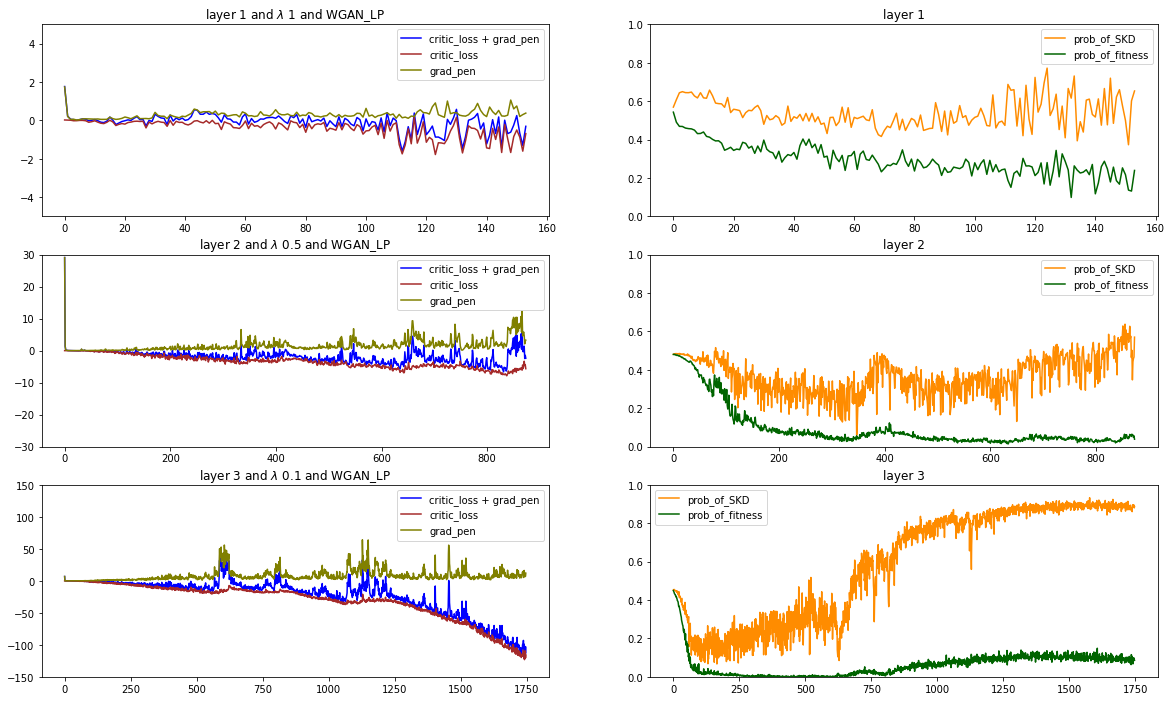

In [145]:
plot_loss_and_probs(result_vocab,[1,0.5,0.1], "WGAN_LP")

In [ ]:
# 1. detect norm - yes
# 2) min and max values of critic
# 3. gradient_penalty is huge -yes
# 4. grad pen and loss separately -yes
# 5. ax.set_ylim [-3,3] -yes

### Noise Distinguishing

Lets prove our critic to compare how critic is able to distinguish filters SKD from noise.

In [148]:
DIM = 128
N_ITERATIONS_1 = 50
N_ITERATIONS_2 = 200
N_ITERATIONS_3 = 400
CRITIC_STEPS = 5 
LAMBDA_1 = 1
LAMBDA_2 = 0.5
LAMBDA_3 = 0.1
LAMBDAS = [LAMBDA_1,LAMBDA_2, LAMBDA_3]
DATA_NOISE = [torch.rand(384,7,7).cuda(),torch.rand(32768,5,5).cuda(),torch.rand(65536,5,5).cuda()]

result_vocab = []
for title,train_load,label,batch,N_ITERATIONS,lmbda,data in tqdm_notebook(zip(["7x7","5x5","5x5"],[train_loader_1,\
                                                               train_loader_2,\
                                                               train_loader_3],\
                                                 ['layer_1','layer_2','layer_3'],[BATCH_1,BATCH_2,BATCH_3],\
                                                 [N_ITERATIONS_1,N_ITERATIONS_2,N_ITERATIONS_3],LAMBDAS,DATA_NOISE)):
  critic = Critic(dim = DIM, size_title = title).cuda() 
  critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3, betas=(0, 0.9))
  NUM_EPOCHS = CRITIC_STEPS * N_ITERATIONS // len(train_load)
  print('Total number of epochs: ' + label[-1] + " critic - num_epochs:", NUM_EPOCHS)
  result_vocab.append(train_discriminator(critic,critic_optimizer,train_load,CRITIC_STEPS, NUM_EPOCHS , label, batch, lmbda,data ))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Total number of epochs: 1 critic - num_epochs: 1
Total number of epochs: 2 critic - num_epochs: 1
Total number of epochs: 3 critic - num_epochs: 1



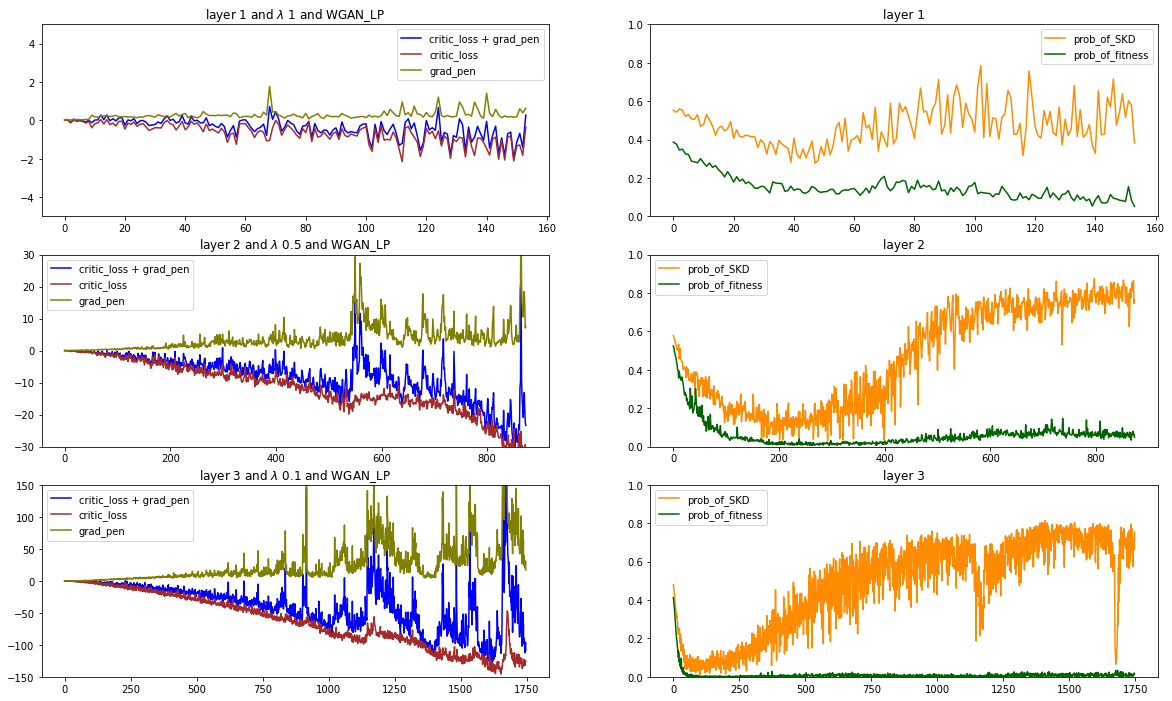

In [149]:
plot_loss_and_probs(result_vocab,[1,0.5,0.1], "WGAN_LP")

### Actual training

Download the data set of CIFAR10

In [141]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000,10000])

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [142]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Plot learning curves

In [198]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(50, 30))

    plt.subplot(4,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(4,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    
    KEY = ['layer_1', 'layer_2','layer_3']
    for num,idx,key in zip([3,5,7], range(3),KEY):
      plt.subplot(4, 2, num)
      plt.title('Loss of critic ' + str(idx + 1), fontsize = 15 )
      plt.plot(history[key]['full_loss'], color = 'blue' , label = 'critic + grad_pen')
      plt.plot(history[key]['critic_loss'], color = 'brown' ,label = 'critic loss')
      plt.plot(history[key]['grap_pen_loss'],color = 'olive',label = 'grad_pen')
      #plt.plot(history[key]['gradient_norm'])
      plt.ylabel('Loss',fontsize = 15)
      plt.xlabel('Iterations',fontsize=15)
      if (num == 3):
        plt.ylim([-5,5])
      elif (num == 5):
        plt.ylim([-30,30])
      else:
        plt.ylim([-150,150])
      plt.legend()

    for num,idx,key in zip([4,6,8],range(3),KEY) :
      plt.subplot(4,2,num)
      plt.title('probabilities of SKD of ' + str(idx + 1) + ' layer and fitness',fontsize=15 )
      plt.plot(history[key]['probs_true'],color='darkorange',label='SKD filters')
      plt.plot(history[key]['probs_fake'],color='darkgreen',label='fitness filters')
      plt.ylabel('Probabilities',fontsize=15)
      plt.xlabel('Iterations',fontsize=15)
      plt.ylim([0,1])
    plt.show()

The following function is the main for training of critic and convolutional neural network:

The plan of training is as follow:

1.   Train the critic the during critic steps with the following loss function:
$$ \mathcal{L}_{critic}(\theta) = critic_{\theta}(w_{fake}) - critic_{\theta}(w_{real}) + \lambda (|| \nabla_{\hat{w}} critic_{\theta}(\hat{w}) ||_{2} -1)^{2}$$ 
where $\hat{w} = \epsilon*w_{real} + (1-\epsilon)*w_{fake}$, whereas $\epsilon$ is sampled from $\mathcal{U}$[0,1]

As we have already said, we use WGAN Lipshitz Penalty instead of WGAN Penalty Gradient:
$$ \mathcal{L}_{critic}(\theta) = critic_{\theta}(w_{fake}) - critic_{\theta}(w_{real}) + \lambda \max \{ 0, (|| \nabla_{\hat{w}} critic_{\theta}(\hat{w}) ||_{2} -1)^{2} \}$$ 

2. Train the neural network:
$$ \mathcal{L}_{network}(w_{fake}) =  CrossEntropyLoss(w_{fake}) - critic(w_{fake}) $$



In [199]:
def train_discriminator_redefine(critic,
                       critic_optimizer,
                       train_loader,
                       critic_steps,
                       num_epochs,
                       title,
                      batch_size,
                       lmbda):
  
    ### parameters ###
    # critic : critic(dim, size_title = ["5x5","7x7"])
    # critic_optimizer: torch.optim.Adam(critic.parameters())
    # train_loader : DataLoader for SKD filters
    # critic_steps : 
    # num_epochs:
    # title : label to get filters from conv_filters_CNN

    assert title in ['layer_1','layer_2','layer_3']
    
    list_vocab = {"full_loss":[],"critic_loss":[],"grap_pen_loss":[],"gradient_norm":[],
                 "probs_true":[],"probs_fake":[]}
    
    
    fake_full_filters = convolutional_weights_CNN[title]
    #fake_full_filters = data

    # fake_full_filters : all current fitness filters of a layer

    # creating of fake sampler
     
    

    
    
    critic.train()
    current_step = 0

    for epoch in range(num_epochs):
        for  real_data in train_loader:
            current_step += 1
      
            real_data = real_data.clone().detach().cuda().float()
            real_data = 2*(real_data - 0.5)
            
            # do critic update
            critic_optimizer.zero_grad()

            # sample fake sample from convolutional Neural Network
            # one bathc torch.Size([batch_size, filters_size, filters_size])
            fake_sampler = fake_data_sampler(real_data.shape[0])
            fake_data = fake_sampler.sample(fake_full_filters)
            
            # to adapt filters for Conv2d
            fake_data = fake_data.unsqueeze(1)
            real_data = real_data.unsqueeze(1)

            # critic loss (WGAN_GP ,WGAN_LP)
            grad_pen = gradient_penalty(critic, real_data, fake_data)[0]
            lipshitz_pen = torch.max(torch.zeros_like(grad_pen), grad_pen)
            value = critic(fake_data).mean() - critic(real_data).mean()
            #d_loss =  value + lmbda*grad_pen
            #lmbda = lmbda*0.9 - unconstant step
            d_loss = value + lmbda*lipshitz_pen

            d_loss.backward()
            critic_optimizer.step()
            #float(grad_pen) to compare
            #float(value)  to compare

            # generator update
            if current_step % critic_steps == 0:
              # there is should be optimizing of generator
              # it will be added a little a bit later, while
              # we define neural network.
              pass

            # to wrap dictionary in iter
            iterator_vocab = iter(list_vocab)

            list_vocab[next(iterator_vocab)].append(d_loss.data.cpu().numpy()) # full_loss
            list_vocab[next(iterator_vocab)].append(value.data.cpu().numpy()) # critic_loss
            list_vocab[next(iterator_vocab)].append(lmbda*lipshitz_pen.data.cpu().numpy()) # lambda*grad_pen
            list_vocab[next(iterator_vocab)].append(gradient_penalty(critic, real_data, fake_data)[1].data.cpu().numpy()) # gradient_norm
            list_vocab[next(iterator_vocab)].append(float(critic(real_data).sigmoid().mean())) # probs_true
            list_vocab[next(iterator_vocab)].append(float(critic(fake_data).sigmoid().mean())) # pros_fake
        
        
            if current_step % critic_steps == 0:
                # finish training of critic
                return list_vocab
                

In [200]:
def train_model(model,
                optimizer_generator,
                num_epochs,
                critics_dictionary,
                critics_optimizer_dictionary,
                train_loader,
                batch_fake,
                val_loader,
                criterion,
                batch_list,
                num_iterations,
                lambdas,
                critic_steps = 100,
                dim =128):
   
  assert isinstance(num_iterations,list)
  assert isinstance(batch_list,list)

  history = defaultdict(lambda: defaultdict(list))

  for epoch in tqdm_notebook(range(num_epochs)):

    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
 
    start_time = time.time()
    ### model train ##
    model.train()
    ### eval all critics ###
    for key in critics_dictionary.keys():
      critics_dictionary[key].eval()

    for batch_x,batch_y in tqdm_notebook(train_loader):
      batch_x,batch_y = batch_x.cuda(),batch_y.cuda()

      optimizer_generator.zero_grad()

 
      ####  calculate loss of pseudo_generator ####
      confusion = list()
      for name, wgt in convolutional_weights_CNN.items():
        # name : name of convolutional NN : ['layer_1','layer_2','layer_3']
        # wgt:  convolutional filters : [torch.Size(128*3,7,7),torch.Size(256*128,5,5),torch.Size(256*256,5,5)]
        # wgt = wgt.detach() : it seems that one hasn't to do so

        fake_sampler = fake_data_sampler(batch_fake)
        fake_data = fake_sampler.sample(wgt).cuda()
        critic = critics_dictionary[name]
        critic.eval() 
        #torch.mean((1 - discriminator(fake_data)).square())
        #loss =  -  torch.mean(0.9*torch.log(torch.exp(discriminator(fake_data) )) - 0.1*torch.log( 1 - torch.exp(discriminator(fake_data)) ))
        #loss = torch.mean( torch.log(1 +  torch.exp( - torch.abs(fake_data)) ) - 0.9*fake_data +  torch.max(fake_data, torch.zeros_like(fake_data)) )
        fake_data = fake_data.unsqueeze(1)
        loss = -critic(fake_data).mean()
        confusion.append(loss)
      ####    finish of calculating  ####
      
      logits = model(batch_x)
      loss_task = criterion(logits, batch_y.long().cuda())

      # in future, one has to tune these parameters (01.12.2020)
      full_loss = 1*loss_task  +  0.1*sum(confusion)
      full_loss.backward()

      optimizer_generator.step()
  

      train_loss += np.sum(full_loss.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      train_acc += np.mean(batch_y.cpu().numpy() == y_pred)

    # calculate loss and accuracy and  save to history of train
    train_loss /= len(train_loader)
    train_acc /= len(train_loader) 
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)

    
    ### critic train ###
    ### model does no train ###
    model.eval()
    for key in critics_dictionary.keys():
      critics_dictionary[key].train()
    
    
    for key,train_load,batch,n_iterations,lmbda in zip(critics_dictionary.keys(),[train_loader_1,train_loader_2,train_loader_3],\
                                    batch_list , num_iterations,lambdas):
      n_epochs_crit = critic_steps * n_iterations // len(train_load)
      result_vocab = train_discriminator_redefine(critics_dictionary[key], critics_optimizer_dictionary[key],\
                                         train_load,critic_steps,n_epochs_crit,key,batch,lmbda)

      history[key]['full_loss'].extend(result_vocab['full_loss'])
      history[key]['critic_loss'].extend(result_vocab['critic_loss'])
      history[key]['grap_pen_loss'].extend(result_vocab['grap_pen_loss'])
      history[key]['gradient_norm'].extend(result_vocab['gradient_norm'])
      history[key]['probs_true'].extend(result_vocab['probs_true'])
      history[key]['probs_fake'].extend(result_vocab['probs_fake'])

      
    ### finishing of critic's train ###
 
    
    ### critic does not train ###
    for key in critics_dictionary.keys():
      critics_dictionary[key].eval()

    for batch_x,batch_y in tqdm_notebook(val_loader):

      batch_x,batch_y = batch_x.cuda(),batch_y.cuda()
      logits = model(batch_x)
      loss_val = criterion(logits, batch_y.long().cuda())
      val_loss += np.sum(loss_val.detach().cpu().numpy())
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      val_acc += np.mean(batch_y.cpu().numpy() == y_pred)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader) 
    history['loss']['val'].append(val_loss)
    history['acc']['val'].append(val_acc)

    clear_output()
        
    #print results after each epoch
    print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
    plot_learning_curves(history)
  return model,history

In [201]:
DIM = 128
critics_dictionary = {}
critics_optimizer_dictionary = {}
for title ,label in zip(["7x7","5x5","5x5"],["layer_1","layer_2","layer_3"]):
  critic = Critic(dim = DIM, size_title = title).cuda()
  critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-5, betas=(0, 0.9))
  if label not in critics_dictionary:
    critics_dictionary[label] = critic
  if label not in critics_optimizer_dictionary:
    critics_optimizer_dictionary[label] = critic_optimizer
  
# critics_dictionary: 

In [202]:
model = SimpleConvNet(n_classes =10).cuda()
convolutional_weights_CNN = {name: structure.weight  for name,structure in model.named_modules() if isinstance(structure,torch.nn.Conv2d) }

In [203]:
convolutional_weights_CNN = {  key: convolutional_weights_CNN[key].reshape(-1,convolutional_weights_CNN[key].shape[-2],\
                                                                           convolutional_weights_CNN[key].shape[-1])         \
                             for key in convolutional_weights_CNN.keys()}

Epoch 20 of 300 took 85.869s
  training loss (in-iteration): 	-2.796929
  validation loss (in-iteration): 	1.415040
  training accuracy: 			96.29 %
  validation accuracy: 			73.09 %


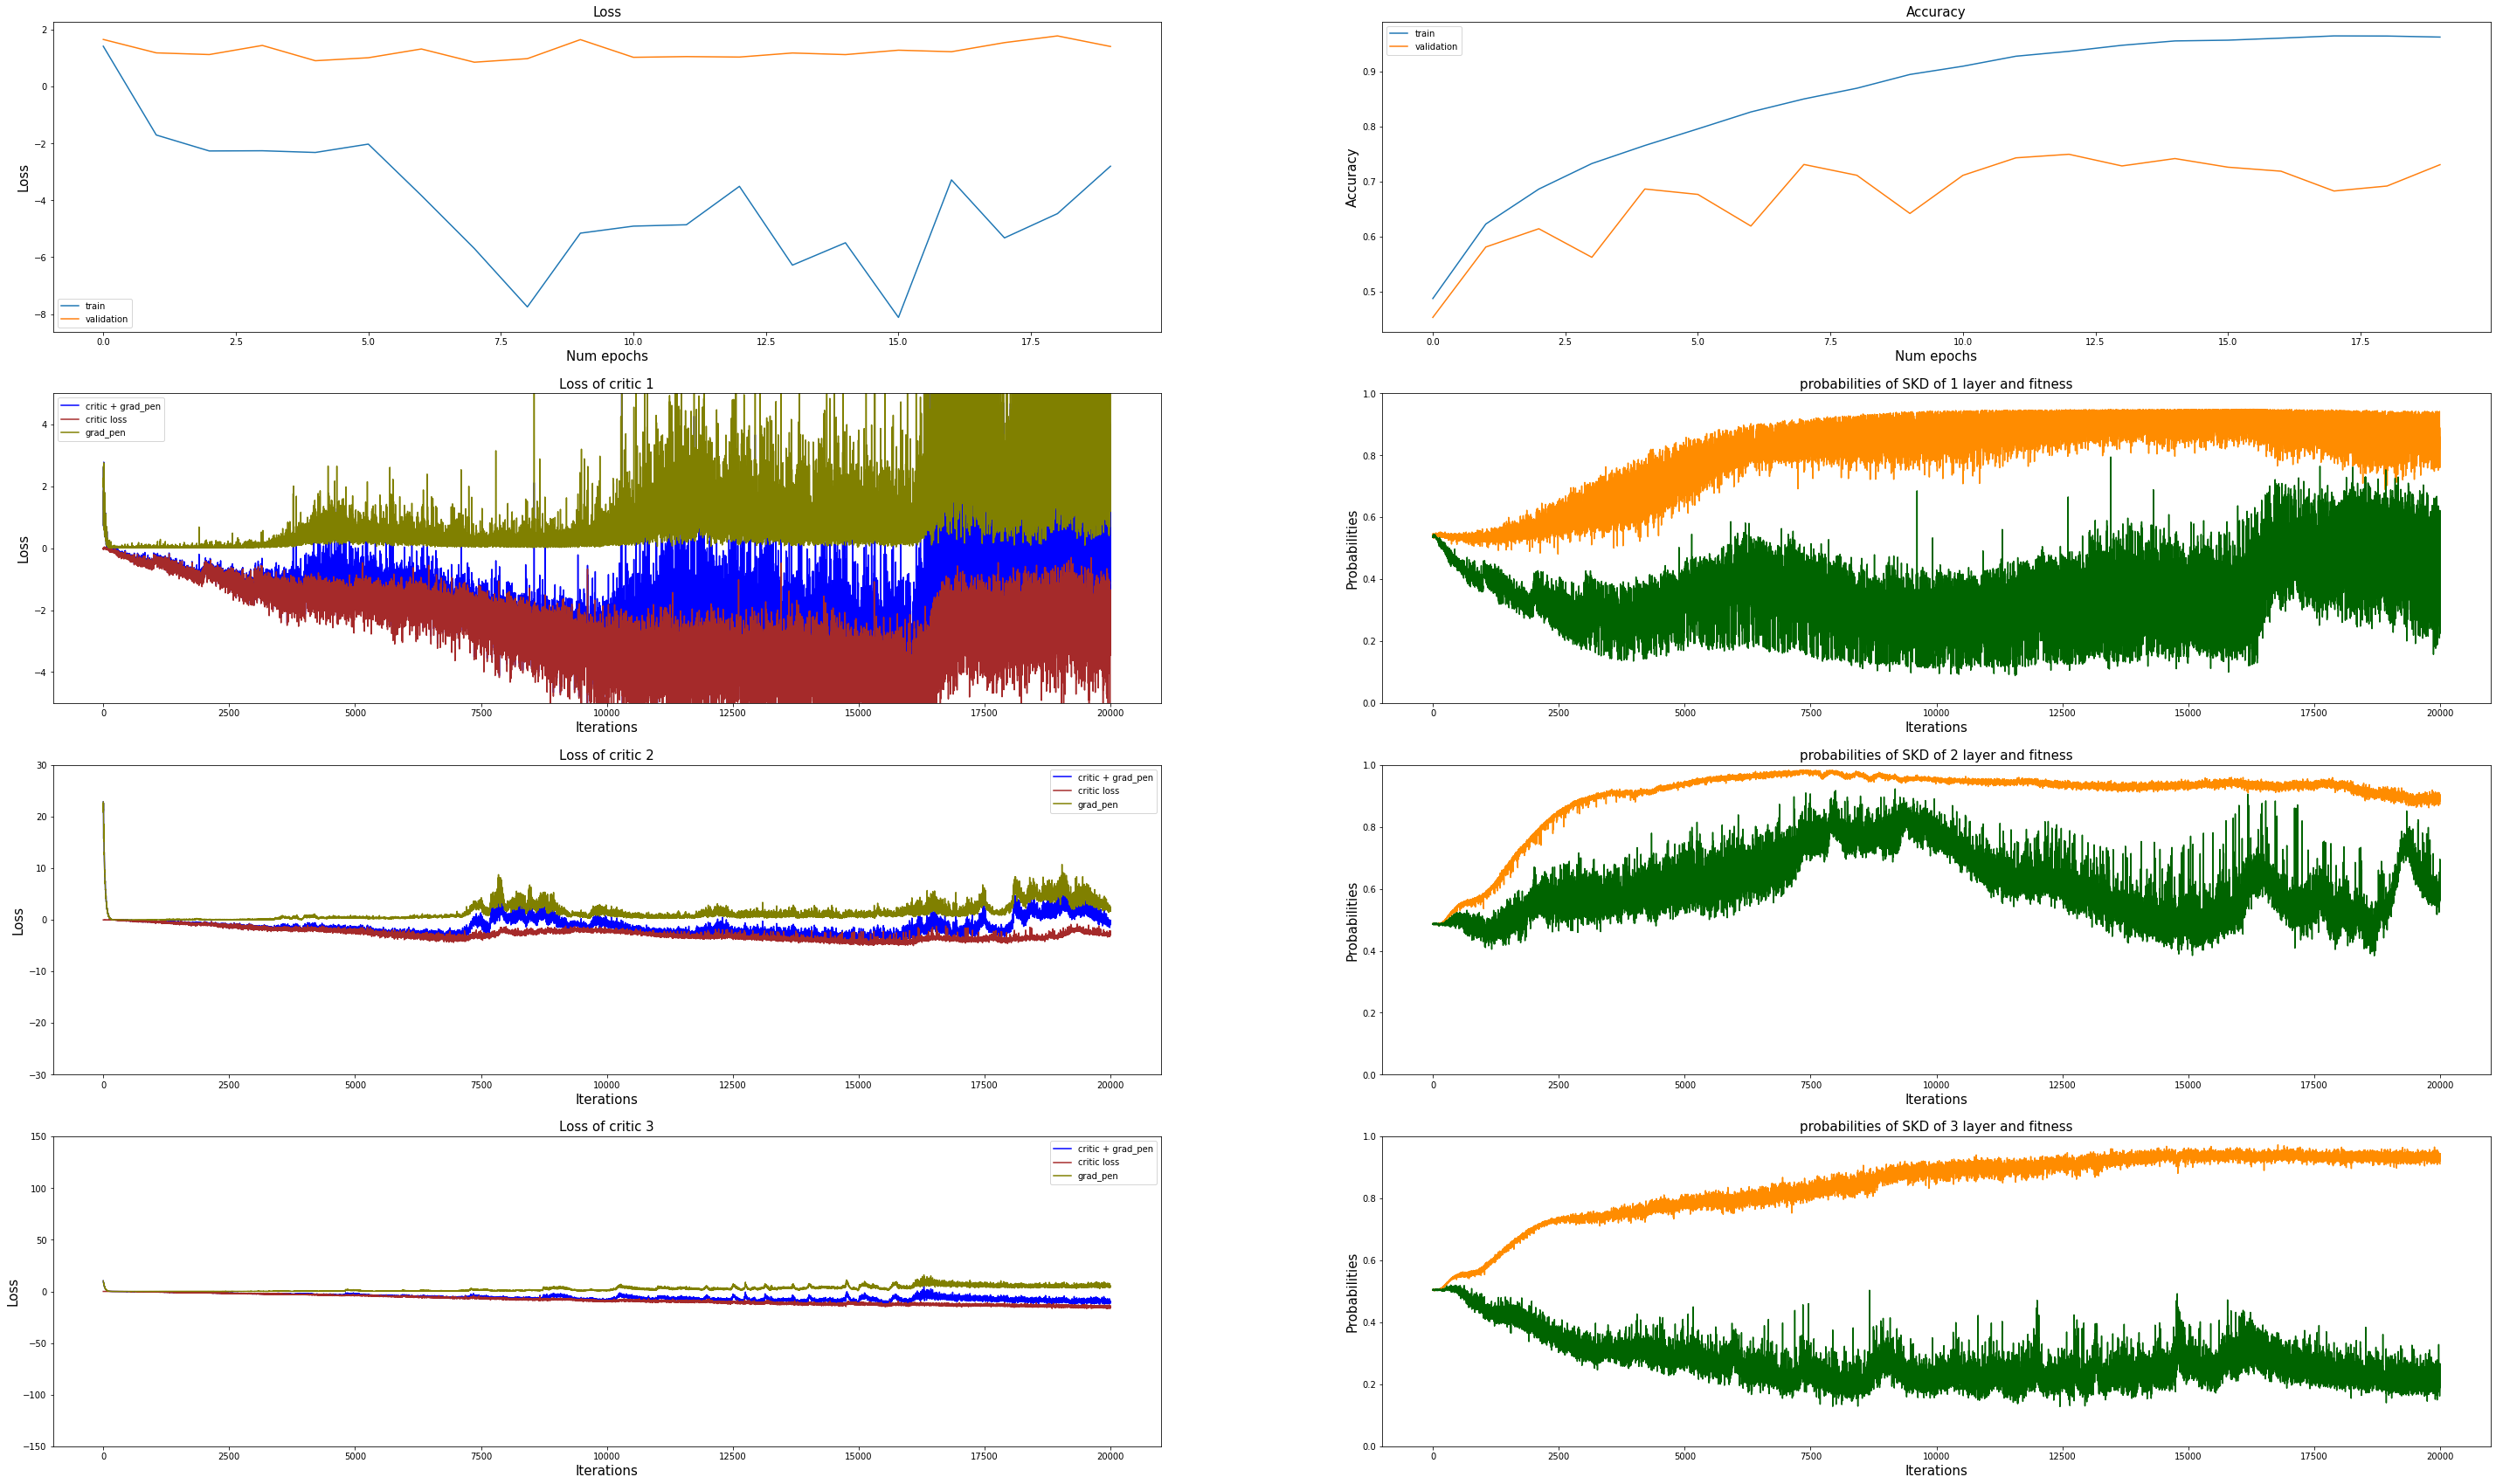

KeyboardInterrupt: ignored

In [204]:
optimizer_generator = torch.optim.Adam(model.parameters(),lr=1e-3)
NUM_EPOCHS = 300
N_ITERATIONS_1 = 50
N_ITERATIONS_2 = 200
N_ITERATIONS_3 = 400
LAMBDA_1 = 1
LAMBDA_2 = 0.5
LAMBDA_3 = 0.1
LAMBDAS = [LAMBDA_1,LAMBDA_2, LAMBDA_3]

criterion = torch.nn.CrossEntropyLoss()
model,history = train_model( model,
                optimizer_generator,
                NUM_EPOCHS,
                critics_dictionary,
                critics_optimizer_dictionary,
                train_loader,30,
                val_loader,
                criterion,
                batch_list = [BATCH_1,BATCH_2,BATCH_3],
                num_iterations = [N_ITERATIONS_1,N_ITERATIONS_2,N_ITERATIONS_3],
                lambdas = LAMBDAS,
                critic_steps = 1000,
                dim=128)